# Notebook 2.3 

**Table of Contents** <br>
* [1. Load Clean Data](#loaddata)
* [2. Hierarchical Clustering](#hier)
    * [2.1 Dendogram](#dendo)
* [3. K-Means Clustering](#kmeans)
    * [3.1 Silhouette Score](#sil)
* [4. Self Organizing Maps](#som)

<hr>
<a class="anchor" id="loaddata">
    
# 1. Load Clean Data
    
</a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering

sns.set(style="ticks", palette=sns.color_palette("icefire", 7))

In [2]:
# load the dataset 
file_path = 'datasets/data_clean.csv'
df = pd.read_csv(file_path)
df.head(2)

,Unnamed: 0,activity,CLV_Score,CUI_diversity,customer_age,DOW_0,DOW_1,DOW_2,DOW_3,DOW_4,...,Monetary_Score,Orders_Afternoon,Orders_Dawn,Orders_Dusk,Orders_Evening,Orders_Morning,Orders_Night,product_count,rcn,Total_Orders_Per_Client
0,0,0.011111,0.465132,0.0,0.107143,0.5,0.0,0.0,0.0,0.0,...,0.306394,0.0,0.0,0.0,0.4,0.0,0.0,0.307692,1.0,0.125
1,1,0.011111,0.452267,0.2,0.071429,0.5,0.0,0.0,0.0,0.0,...,0.202472,0.0,0.0,0.0,0.0,1.0,0.0,0.076923,1.0,0.125


In [3]:
df.columns

Index(['Unnamed: 0', 'activity', 'CLV_Score', 'CUI_diversity', 'customer_age',
       'DOW_0', 'DOW_1', 'DOW_2', 'DOW_3', 'DOW_4', 'DOW_5', 'DOW_6',
       'first_order', 'Frequency_Score', 'Loyalty', 'mnt', 'Monetary_Score',
       'Orders_Afternoon', 'Orders_Dawn', 'Orders_Dusk', 'Orders_Evening',
       'Orders_Morning', 'Orders_Night', 'product_count', 'rcn',
       'Total_Orders_Per_Client'],
      dtype='object')

In [4]:
columns_to_drop = ['Unnamed: 0', # drop the column 'unnamed: 0'
                   'activity', 'CLV_Score', 'first_order', 'Frequency_Score',  'Monetary_Score', 'rcn', # exploring other perspectives
                   'DOW_0', 'DOW_1', 'DOW_2', 'DOW_3', 'DOW_4', 'DOW_5', 'DOW_6',
                   'Orders_Afternoon', 'Orders_Dawn', 'Orders_Dusk', 'Orders_Evening', 'Orders_Morning', 'Orders_Night']
df = df.drop(columns=columns_to_drop)
df.head(10)

,CUI_diversity,customer_age,Loyalty,mnt,product_count,Total_Orders_Per_Client
0,0.0,0.107143,0.0,0.306394,0.307692,0.125
1,0.2,0.071429,0.0,0.202472,0.076923,0.125
2,0.0,0.821429,0.6,0.094895,0.076923,0.125
3,0.2,0.428571,0.0,0.335196,0.153846,0.125
4,0.2,0.178571,0.0,0.591832,0.307692,0.125
5,0.0,0.892857,0.0,0.263837,0.076923,0.125
6,0.2,0.321429,0.0,0.075658,0.076923,0.125
7,0.2,0.428571,0.0,0.384095,0.153846,0.125
8,0.4,0.178571,0.0,0.151209,0.230769,0.250
9,0.0,0.178571,0.0,0.345083,0.153846,0.125


<hr>
<a class="anchor" id="hier">
    
# 2. Hierarchical Clustering
    
</a>

In [5]:
def get_r2_hc(df, link_method, max_nclus, min_nclus=1, dist="euclidean"):
    """This function computes the R2 for a set of cluster solutions given by the application of a hierarchical method.
    The R2 is a measure of the homogenity of a cluster solution. It is based on SSt = SSw + SSb and R2 = SSb/SSt. 
    
    Parameters:
    df (DataFrame): Dataset to apply clustering
    link_method (str): either "ward", "complete", "average", "single"
    max_nclus (int): maximum number of clusters to compare the methods
    min_nclus (int): minimum number of clusters to compare the methods. Defaults to 1.
    dist (str): distance to use to compute the clustering solution. Must be a valid distance. Defaults to "euclidean".
    
    Returns:
    ndarray: R2 values for the range of cluster solutions
    """
    
    r2 = []  # where we will store the R2 metrics for each cluster solution
    feats = df.columns.tolist()
    
    for i in range(min_nclus, max_nclus+1):  # iterate over desired ncluster range
        cluster = AgglomerativeClustering(n_clusters=i, metric=dist, linkage=link_method)
        
        #get cluster labels
        hclabels = cluster.fit_predict(df) 
        
        # concat df with labels
        df_concat = pd.concat([df, pd.Series(hclabels, name='labels', index=df.index)], axis=1)  
        
        
        # append the R2 of the given cluster solution
        r2.append(get_rsq(df_concat, feats, 'labels'))
        
    return np.array(r2)

In [6]:
# Let's wrap them into functions

def get_ss(df, feats):
    """
    Calculate the sum of squares (SS) for the given DataFrame.

    The sum of squares is computed as the sum of the variances of each column
    multiplied by the number of non-NA/null observations minus one.

    Parameters:
    df (pandas.DataFrame): The input DataFrame for which the sum of squares is to be calculated.
    feats (list of str): A list of feature column names to be used in the calculation.

    Returns:
    float: The sum of squares of the DataFrame.
    """
    df_ = df[feats]
    ss = np.sum(df_.var() * (df_.count() - 1))
    
    return ss 


def get_ssb(df, feats, label_col):
    """
    Calculate the between-group sum of squares (SSB) for the given DataFrame.
    The between-group sum of squares is computed as the sum of the squared differences
    between the mean of each group and the overall mean, weighted by the number of observations
    in each group.

    Parameters:
    df (pandas.DataFrame): The input DataFrame containing the data.
    feats (list of str): A list of feature column names to be used in the calculation.
    label_col (str): The name of the column in the DataFrame that contains the group labels.
    
    Returns
    float: The between-group sum of squares of the DataFrame.
    """
    
    ssb_i = 0
    for i in np.unique(df[label_col]):
        df_ = df.loc[:, feats]
        X_ = df_.values
        X_k = df_.loc[df[label_col] == i].values
        
        ssb_i += (X_k.shape[0] * (np.square(X_k.mean(axis=0) - X_.mean(axis=0))) )

    ssb = np.sum(ssb_i)
    

    return ssb


def get_ssw(df, feats, label_col):
    """
    Calculate the sum of squared within-cluster distances (SSW) for a given DataFrame.

    Parameters:
    df (pandas.DataFrame): The input DataFrame containing the data.
    feats (list of str): A list of feature column names to be used in the calculation.
    label_col (str): The name of the column containing cluster labels.

    Returns:
    float: The sum of squared within-cluster distances (SSW).
    """
    feats_label = feats+[label_col]

    df_k = df[feats_label].groupby(by=label_col).apply(lambda col: get_ss(col, feats), 
                                                       include_groups=False)

    return df_k.sum()


In [7]:
# 
def get_rsq(df, feats, label_col):
    """
    Calculate the R-squared value for a given DataFrame and features.

    Parameters:
    df (pd.DataFrame): The input DataFrame containing the data.
    feats (list): A list of feature column names to be used in the calculation.
    label_col (str): The name of the column containing the labels or cluster assignments.

    Returns:
    float: The R-squared value, representing the proportion of variance explained by the clustering.
    """

    df_sst_ = get_ss(df, feats)                 # get total sum of squares
    df_ssw_ = get_ssw(df, feats, label_col)     # get ss within
    df_ssb_ = df_sst_ - df_ssw_                 # get ss between

    # r2 = ssb/sst 
    return (df_ssb_/df_sst_)

In [ ]:
##########################################
# THIS TAKES A FEW MINUTES TO RUN!!
##########################################

hc_methods = ["ward", "complete", "average", "single"]
max_nclus = 10

r2_hc = np.vstack([ get_r2_hc(df, 
                              link, 
                              max_nclus=max_nclus, 
                              min_nclus=1, 
                              dist="euclidean") 
                              for link in hc_methods])
### Time to Complete: 31min 53s ###

In [9]:
r2_hc_methods = pd.DataFrame(r2_hc.T, index=range(1, max_nclus + 1), columns=hc_methods)

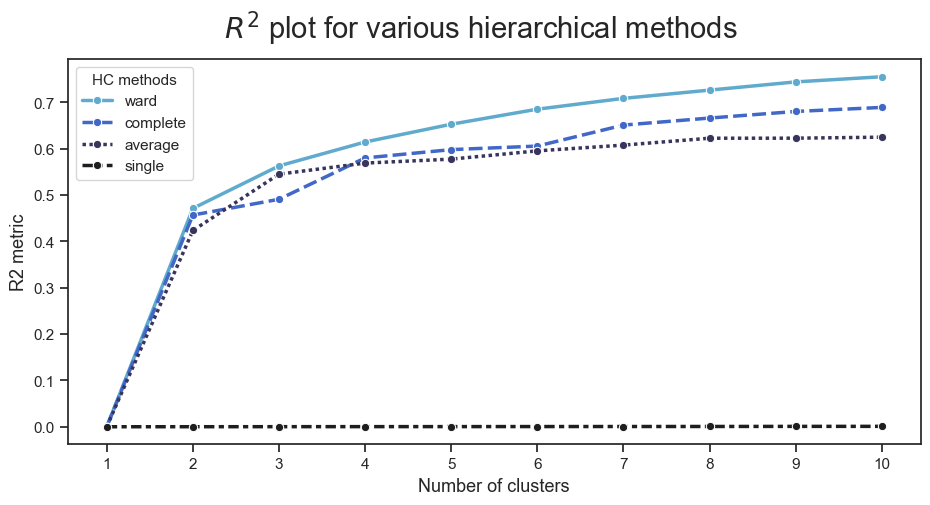

In [10]:
# Plot data
fig = plt.figure(figsize=(11,5))
sns.lineplot(data=r2_hc_methods, linewidth=2.5, markers=["o"]*4)

# Finalize the plot
plt.legend(title="HC methods", title_fontsize=11)
plt.xticks(range(1, max_nclus + 1))
plt.xlabel("Number of clusters", fontsize=13)
plt.ylabel("R2 metric", fontsize=13)

fig.suptitle("$R^2$ plot for various hierarchical methods", fontsize=21)

plt.show()

<hr>
<a class="anchor" id="dendo">
    
## 2.1 Dendogram
    
</a>

In [11]:
# setting distance_threshold=0 and n_clusters=None ensures we compute the full tree
linkage = 'ward'
distance = 'euclidean'


hclust = AgglomerativeClustering(linkage=linkage, metric=distance, distance_threshold=0, n_clusters=None)
hclust.fit_predict(df)

array([25055, 20780, 21773, ...,     5,     2,     0])

In [12]:
# Adapted from:
# https://scikit-learn.org/stable/auto_examples/cluster/plot_agglomerative_dendrogram.html#sphx-glr-auto-examples-cluster-plot-agglomerative-dendrogram-py

# create the counts of samples under each node (number of points being merged)
counts = np.zeros(hclust.children_.shape[0])
n_samples = len(hclust.labels_)

# hclust.children_ contains the observation ids that are being merged together
# At the i-th iteration, children[i][0] and children[i][1] are merged to form node n_samples + i
for i, merge in enumerate(hclust.children_):
    # track the number of observations in the current cluster being formed
    current_count = 0
    for child_idx in merge:
        if child_idx < n_samples:
            # If this is True, then we are merging an observation
            current_count += 1  # leaf node
        else:
            # Otherwise, we are merging a previously formed cluster
            current_count += counts[child_idx - n_samples]
    counts[i] = current_count

# the hclust.children_ is used to indicate the two points/clusters being merged (dendrogram's u-joins)
# the hclust.distances_ indicates the distance between the two points/clusters (height of the u-joins)
# the counts indicate the number of points being merged (dendrogram's x-axis)
linkage_matrix = np.column_stack(
    [hclust.children_, hclust.distances_, counts]
).astype(float)

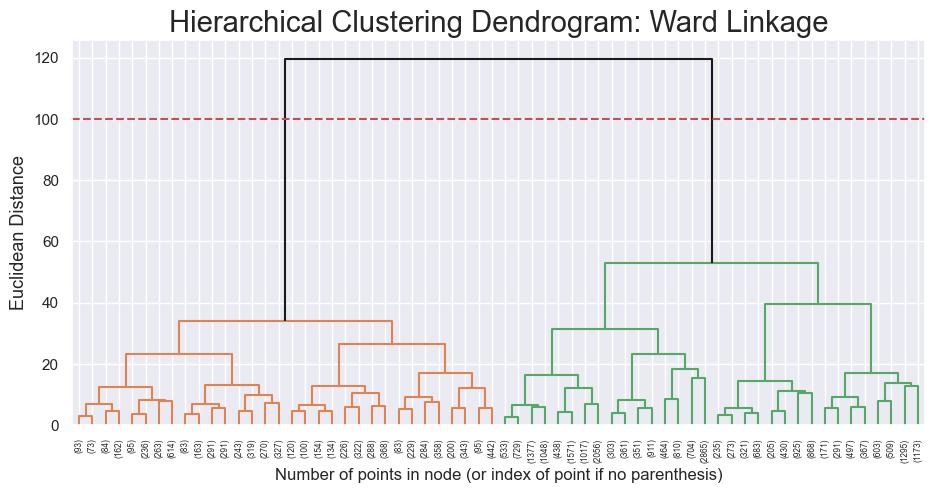

In [13]:
# Plot the corresponding dendrogram
sns.set()
fig = plt.figure(figsize=(11,5))
# The Dendrogram parameters need to be tuned
y_threshold = 100
dendrogram(linkage_matrix, truncate_mode='level', p=5, color_threshold=y_threshold, above_threshold_color='k')
plt.hlines(y_threshold, 0, 1000, colors="r", linestyles="dashed")
plt.title(f'Hierarchical Clustering Dendrogram: {linkage.title()} Linkage', fontsize=21)
plt.xlabel('Number of points in node (or index of point if no parenthesis)')
plt.ylabel(f'{distance.title()} Distance', fontsize=13)
plt.show()

In [14]:
linkage = 'ward'
distance = 'euclidean'

In [15]:
# 4 cluster solution
n_clusters = 4

hc4_clust = AgglomerativeClustering(linkage=linkage, metric=distance, n_clusters=n_clusters)
hc4_labels = hc4_clust.fit_predict(df)

In [16]:
# Characterizing the 4 clusters
df_concat = pd.concat([df, 
                       pd.Series(hc4_labels, 
                                 name='labels', 
                                 index=df.index)], 
                    axis=1)

df_concat.groupby('labels').mean()

,CUI_diversity,customer_age,Loyalty,mnt,product_count,Total_Orders_Per_Client
labels,,,,,,
0,0.554005,0.458967,0.406002,0.744222,0.769932,0.825717
1,0.096127,0.431097,0.553815,0.274207,0.229076,0.289926
2,0.101210,0.450405,0.001679,0.205250,0.099879,0.099643
3,0.457868,0.356672,0.107785,0.308041,0.320617,0.410470


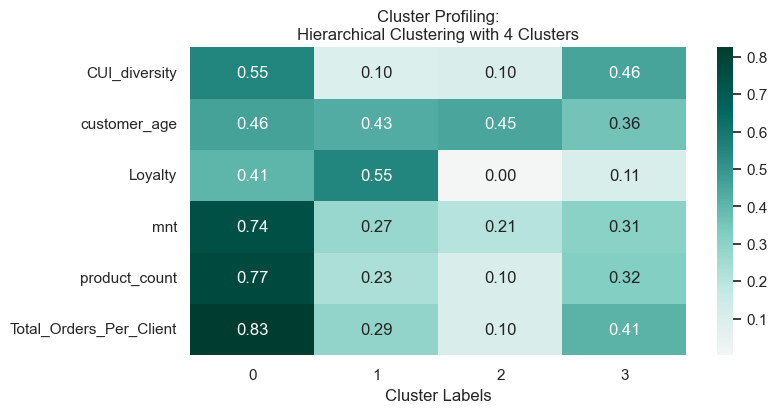

In [17]:
fig, ax = plt.subplots(figsize=(8,4))

hc_profile = df_concat.groupby('labels').mean().T

sns.heatmap(hc_profile,
            center=0, annot=True, cmap="BrBG", fmt=".2f",
            ax=ax 
            )

ax.set_xlabel("Cluster Labels")
ax.set_title("Cluster Profiling:\nHierarchical Clustering with 4 Clusters")
plt.show()

In [18]:
# 5 cluster solution
n_clusters=5

hc5_clust = AgglomerativeClustering(linkage=linkage, metric=distance, n_clusters=n_clusters)
hc5_labels = hc5_clust.fit_predict(df)

In [19]:
# Characterizing the 5 clusters
df_concat = pd.concat([df, 
                       pd.Series(hc5_labels, 
                                 name='labels', 
                                 index=df.index)], 
                    axis=1)

df_concat.groupby('labels').mean()

,CUI_diversity,customer_age,Loyalty,mnt,product_count,Total_Orders_Per_Client
labels,,,,,,
0,0.101210,0.450405,0.001679,0.205250,0.099879,0.099643
1,0.782257,0.442770,0.330405,0.748285,0.877866,0.938418
2,0.334223,0.474563,0.478794,0.740310,0.666003,0.717198
3,0.457868,0.356672,0.107785,0.308041,0.320617,0.410470
4,0.096127,0.431097,0.553815,0.274207,0.229076,0.289926


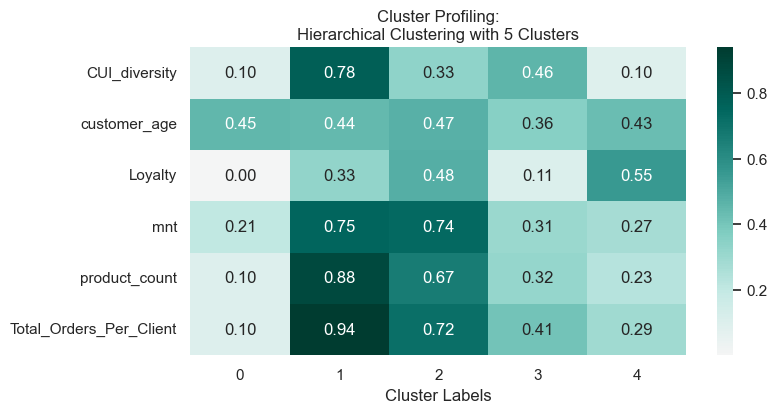

In [20]:
fig, ax = plt.subplots(figsize=(8,4))

hc_profile = df_concat.groupby('labels').mean().T

sns.heatmap(hc_profile,
            center=0, annot=True, cmap="BrBG", fmt=".2f",
            ax=ax 
            )

ax.set_xlabel("Cluster Labels")
ax.set_title("Cluster Profiling:\nHierarchical Clustering with 5 Clusters")
plt.show()

<hr>
<a class="anchor" id="kmeans">
    
# 3. K-Means Clustering
    
</a>

In [21]:
kmclust = KMeans(n_clusters=8, # The number of clusters to form as well as the number of centroids to generate
                 init='random', # Choose n_clusters observations (rows) at random from data for the initial centroids.
                 n_init=10, # Number of times the k-means algorithm is run with different centroid seeds
                 random_state=1) # random seed to initialize centroids
kmclust.fit(df)

KMeans(init='random', n_init=10, random_state=1)

In [22]:
# the predict method
kmclust.predict(df)

array([5, 5, 7, ..., 5, 0, 5], dtype=int32)

In [23]:
# the transform method
pd.DataFrame(kmclust.transform(df))

,0,1,2,3,4,5,6,7
0,0.727999,1.325777,1.533105,0.804077,0.947291,0.380324,0.440902,0.688040
1,0.721073,1.448176,1.601777,0.918375,0.948356,0.309388,0.395713,0.719728
2,0.595286,1.342626,1.711938,1.117981,1.101566,0.781937,0.852333,0.498442
3,0.396071,1.311789,1.465948,0.704861,0.814831,0.274908,0.239791,0.617569
4,0.757310,1.206990,1.339614,0.557135,0.837795,0.549049,0.404940,0.736067
...,...,...,...,...,...,...,...,...
31732,0.321008,1.543186,1.764549,0.989952,1.091665,0.228342,0.538053,0.702969
31733,0.410301,1.540437,1.761787,0.986627,1.089160,0.141846,0.511350,0.693207
31734,0.506611,1.546140,1.766541,0.996573,1.097586,0.104320,0.506954,0.700203
31735,0.238422,1.583465,1.803275,1.052938,1.122972,0.360943,0.616993,0.749732


In [24]:
# Different initialization method and provide more n_init
kmclust = KMeans(n_clusters=8, 
                 init='k-means++', # default=’k-means++’: selects initial cluster centroids using sampling based on an empirical probability distribution of the points’ contribution to the overall inertia.
                 n_init=15, # the n_init the better probability of getting a good solution 
                 random_state=1)
kmclust.fit(df)

KMeans(n_init=15, random_state=1)

In [25]:
kmclust.predict(df)

array([2, 2, 7, ..., 2, 4, 2], dtype=int32)

## Defining the number of clusters

In [26]:
range_clusters = range(1, 11)

In [27]:
inertia = []
for n_clus in range_clusters:  # iterate over desired ncluster range
    kmclust = KMeans(n_clusters=n_clus, init='k-means++', n_init=15, random_state=1)
    kmclust.fit(df)
    inertia.append(kmclust.inertia_)  # save the inertia of the given cluster solution

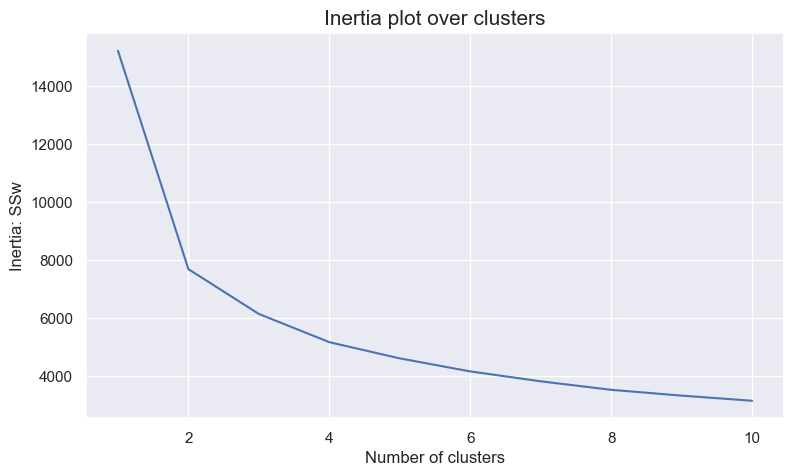

In [28]:
# The inertia plot
plt.figure(figsize=(9,5))
plt.plot(range_clusters, inertia)
plt.ylabel("Inertia: SSw")
plt.xlabel("Number of clusters")
plt.title("Inertia plot over clusters", size=15)
plt.show()

<hr>
<a class="anchor" id="sil">
    
## 3.1 Silhoutte Score
    
</a>

---

**Silhouette Coefficient formula for a single sample:**
$$s = \frac{b - a}{max(a, b)}$$
, where:
- $a$: The mean distance between a sample and all other points in the same cluster.
- $b$: The mean distance between a sample and all other points in the next nearest cluster

---

For n_clusters = 2, the average silhouette_score is : 0.4804105828154687
For n_clusters = 3, the average silhouette_score is : 0.3310086849461905
For n_clusters = 4, the average silhouette_score is : 0.3479548916254268
For n_clusters = 5, the average silhouette_score is : 0.2919007118299722
For n_clusters = 6, the average silhouette_score is : 0.28230838707331557
For n_clusters = 7, the average silhouette_score is : 0.2932544514794617
For n_clusters = 8, the average silhouette_score is : 0.27644533230533685
For n_clusters = 9, the average silhouette_score is : 0.27640560995665914
For n_clusters = 10, the average silhouette_score is : 0.25404284309341546


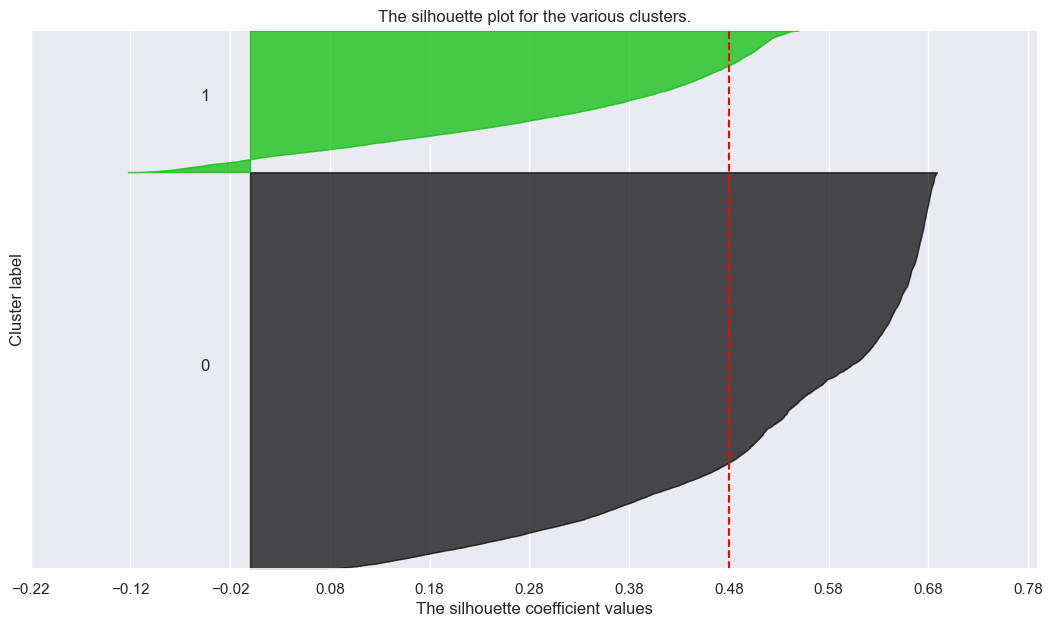

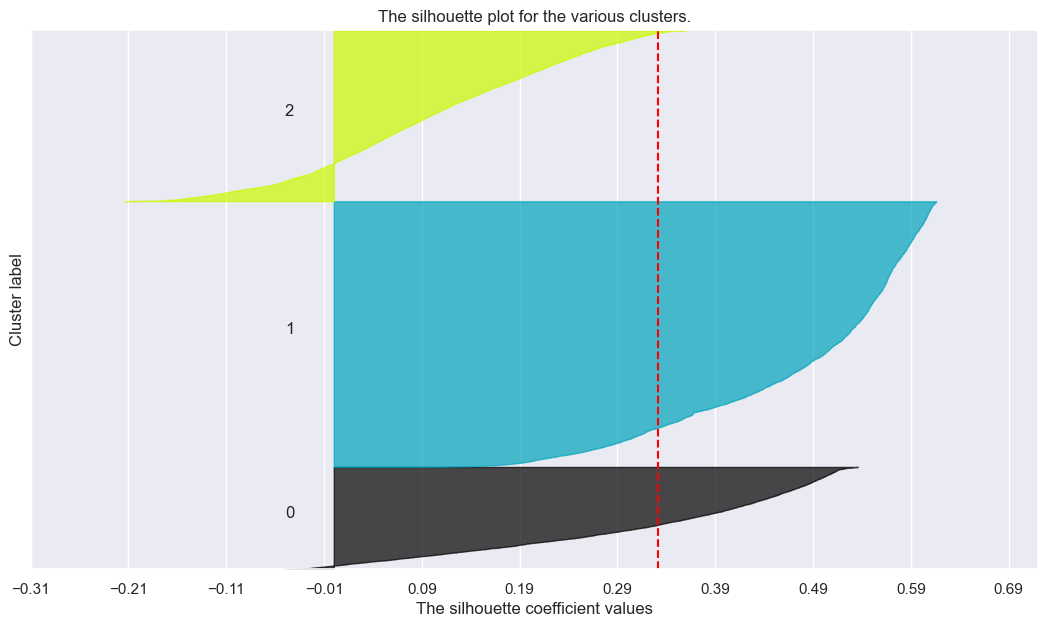

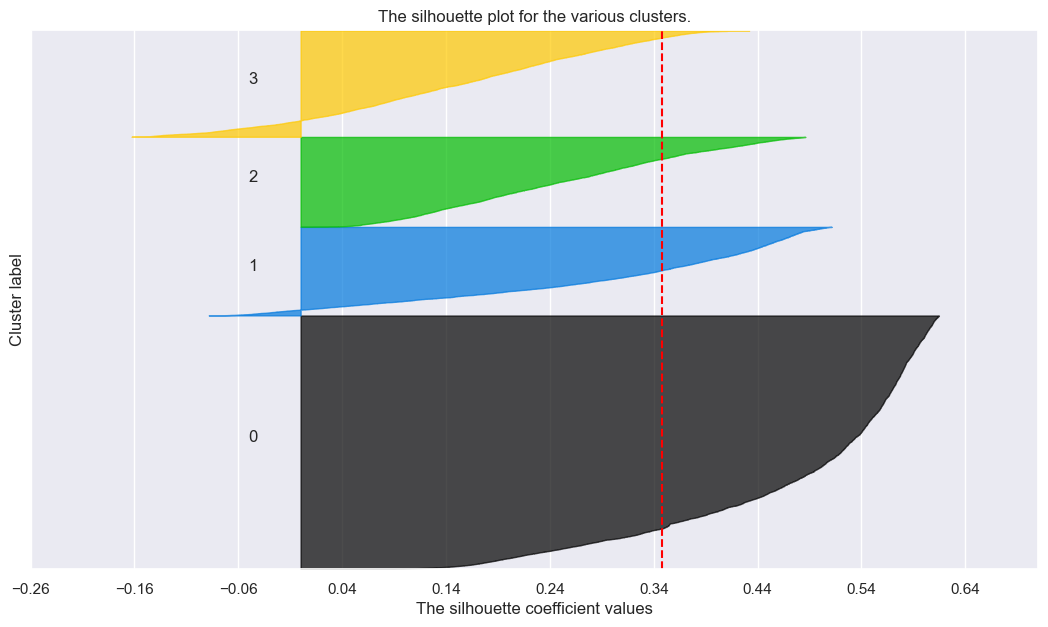

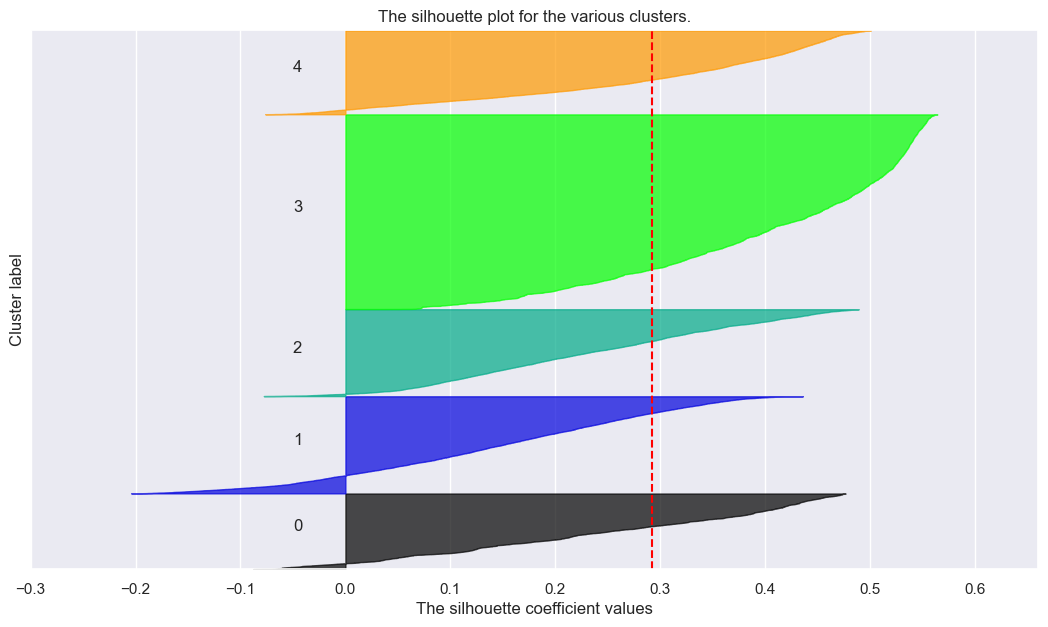

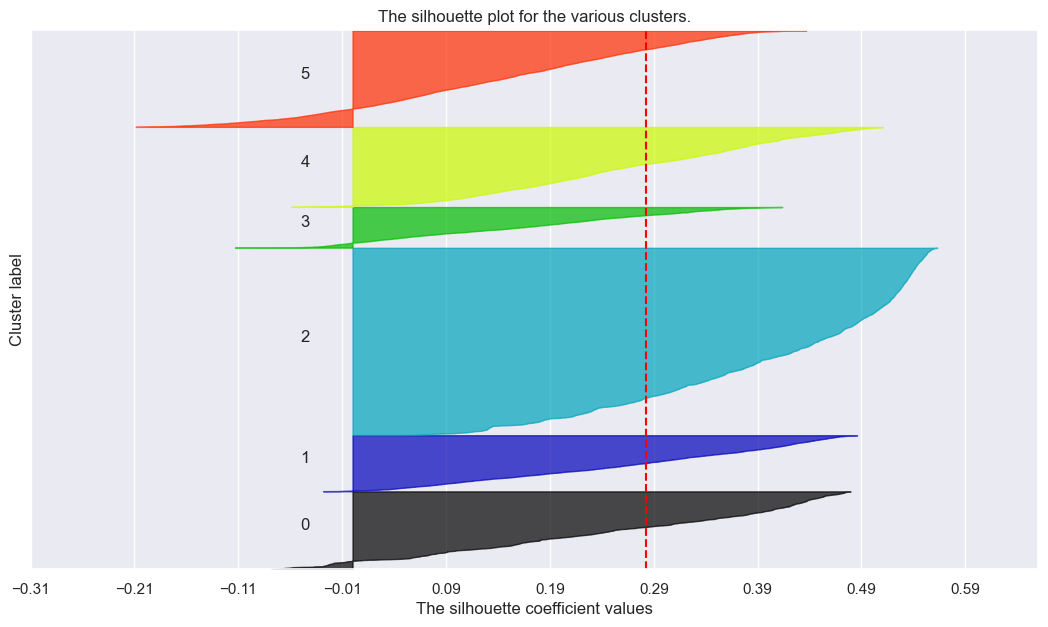

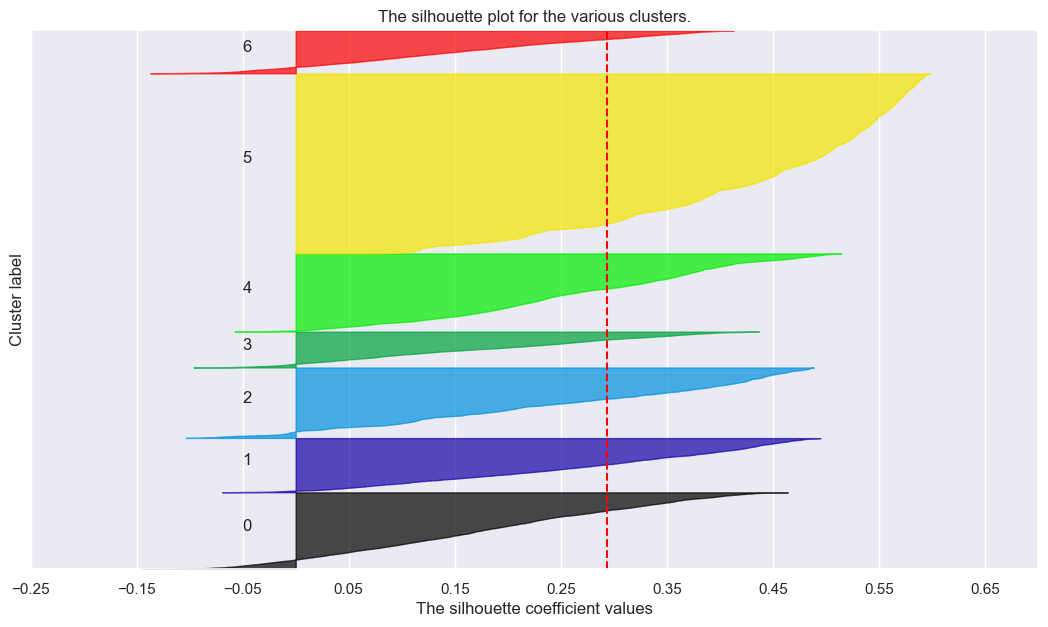

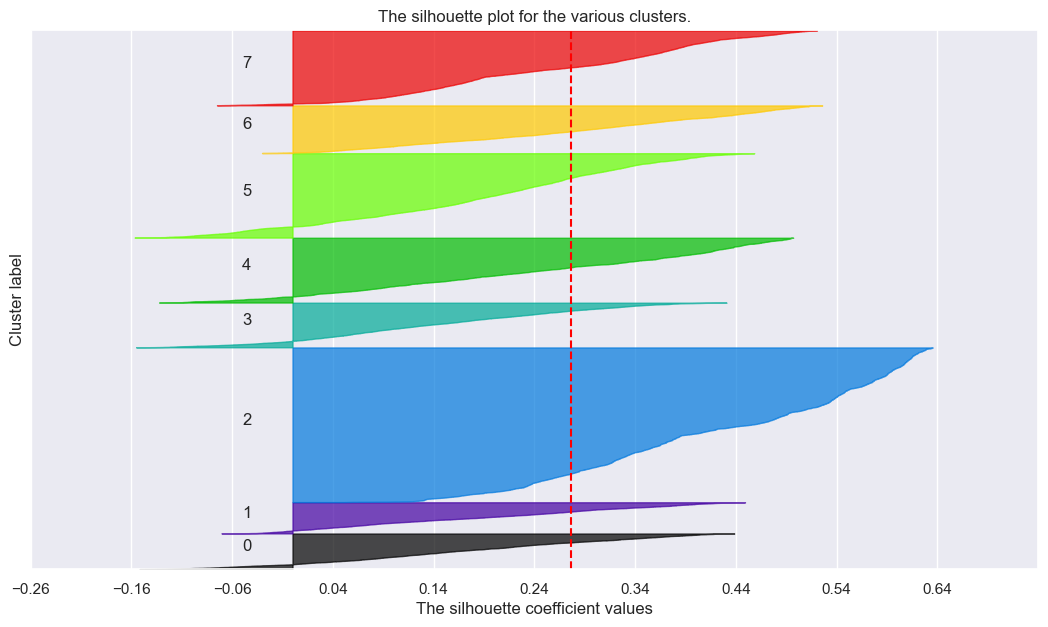

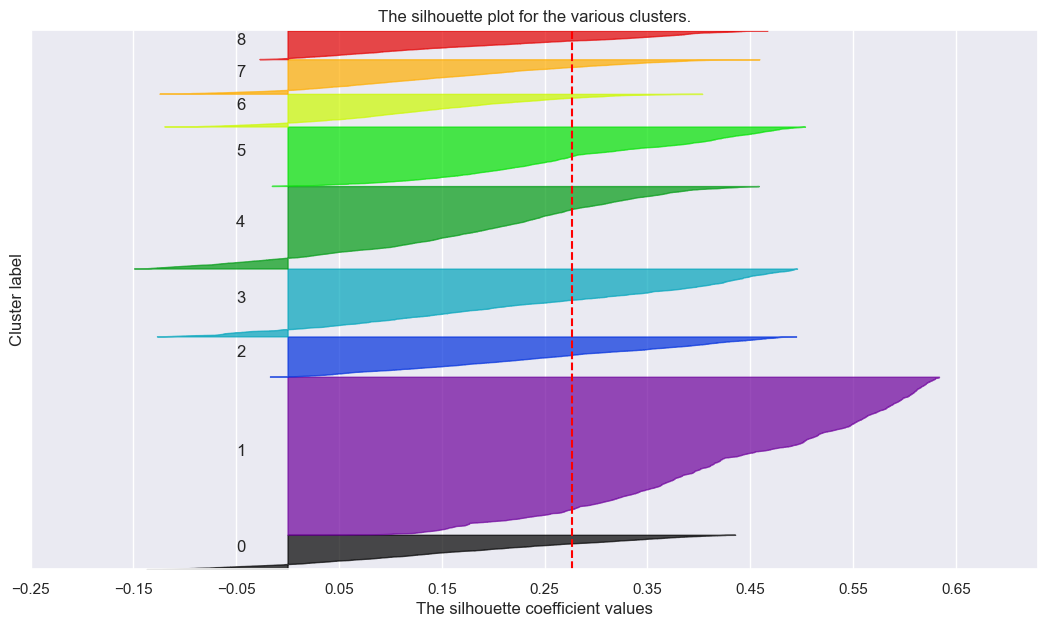

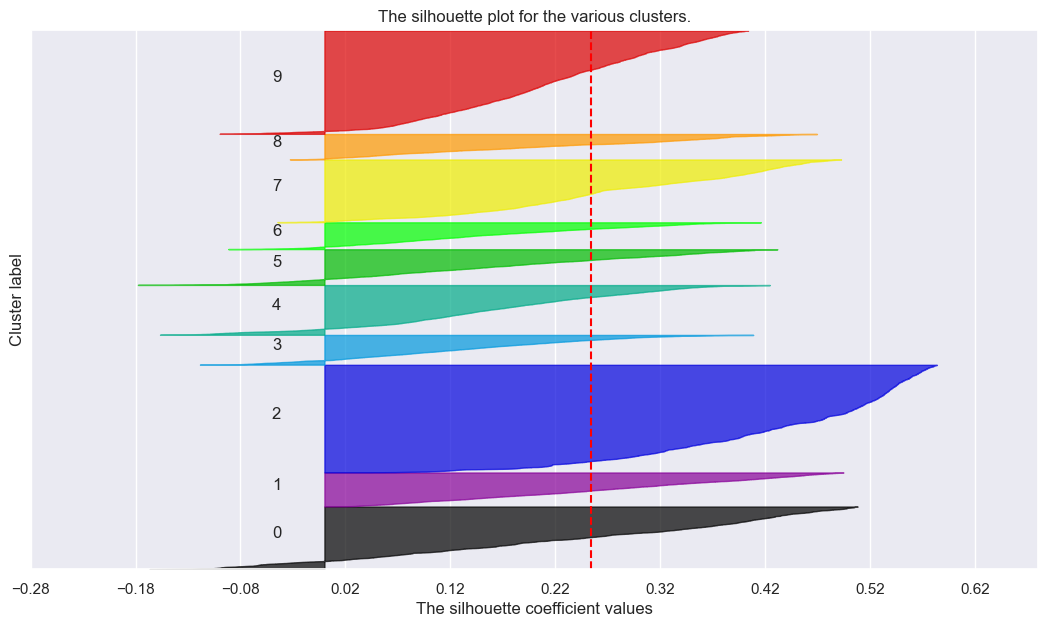

In [ ]:
# Adapted from:
# https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html#sphx-glr-auto-examples-cluster-plot-kmeans-silhouette-analysis-py

# Storing average silhouette metric
avg_silhouette = []
for nclus in range_clusters:
    # Skip nclus == 1
    if nclus == 1:
        continue
    
    # Create a figure
    fig = plt.figure(figsize=(13, 7))

    # Initialize the KMeans object with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    kmclust = KMeans(n_clusters=nclus, init='k-means++', n_init=15, random_state=1)
    cluster_labels = kmclust.fit_predict(df)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed clusters
    silhouette_avg = silhouette_score(df, cluster_labels)
    avg_silhouette.append(silhouette_avg)
    print(f"For n_clusters = {nclus}, the average silhouette_score is : {silhouette_avg}")

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(df, cluster_labels)

    y_lower = 10
    for i in range(nclus):
        # Aggregate the silhouette scores for samples belonging to cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()
        
        # Get y_upper to demarcate silhouette y range size
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        
        # Filling the silhouette
        color = cm.nipy_spectral(float(i) / nclus)
        plt.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        plt.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    plt.title("The silhouette plot for the various clusters.")
    plt.xlabel("The silhouette coefficient values")
    plt.ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    plt.axvline(x=silhouette_avg, color="red", linestyle="--")
    
    # The silhouette coefficient can range from -1, 1
    xmin, xmax = np.round(sample_silhouette_values.min() -0.1, 2), np.round(sample_silhouette_values.max() + 0.1, 2)
    plt.xlim([xmin, xmax])
    
    # The (nclus+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    plt.ylim([0, len(df) + (nclus + 1) * 10])

    plt.yticks([])  # Clear the yaxis labels / ticks
    plt.xticks(np.arange(xmin, xmax, 0.1))

### Time to Complete: 4min 54s ###

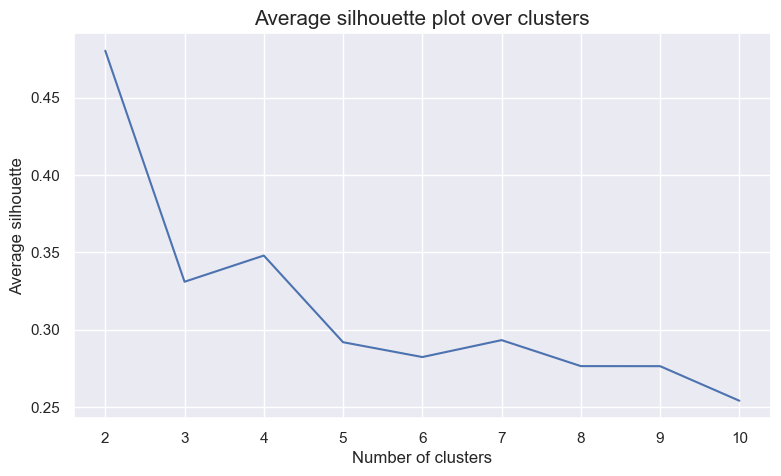

In [30]:
# The average silhouette plot
# The inertia plot
plt.figure(figsize=(9,5))
plt.plot(range_clusters[1:], ## Plot X-axis; Why range_clusters[1:] ? Remember we skipped k=1 in the cell above
         avg_silhouette)     ## Plot Y-axis

plt.ylabel("Average silhouette")
plt.xlabel("Number of clusters")
plt.title("Average silhouette plot over clusters", size=15)
plt.show()

### Final KMeans clustering solution

In [31]:
# final cluster solution
number_clusters = 2
kmclust = KMeans(n_clusters=number_clusters, init='k-means++', n_init=15, random_state=1)
km_labels = kmclust.fit_predict(df)
km_labels

array([0, 0, 0, ..., 0, 0, 0], dtype=int32)

In [32]:
# Display the mean for each variable in each cluster
df_concat = pd.concat((df, pd.Series(km_labels, name='labels', index=df.index)), axis=1)
df_concat.groupby('labels').mean()

,CUI_diversity,customer_age,Loyalty,mnt,product_count,Total_Orders_Per_Client
labels,,,,,,
0,0.143378,0.436330,0.120590,0.227986,0.146844,0.168694
1,0.547286,0.441797,0.399246,0.705378,0.738662,0.804316


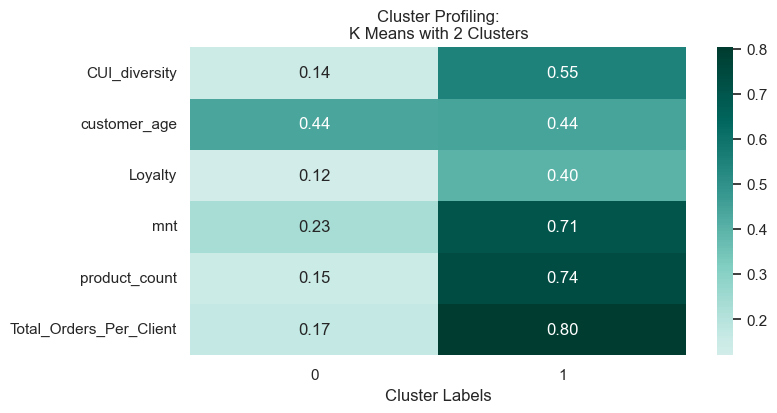

In [34]:
fig, ax = plt.subplots(figsize=(8,4))

hc_profile = df_concat.groupby('labels').mean().T

sns.heatmap(hc_profile,
            center=0, annot=True, cmap="BrBG", fmt=".2f",
            ax=ax 
            )

ax.set_xlabel("Cluster Labels")
ax.set_title("Cluster Profiling:\nK Means with 2 Clusters")
plt.show()